# Visualizing Glove word embeddings

## By: Eric S. Tellez

This example creates a visualization of Glove word embeddings using `Embeddings.jl` package to fetch them.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="Embeddings"),
    PackageSpec(name="JLD2"),
    PackageSpec(name="Plots"),
    PackageSpec(name="HypertextLiteral"),
])

using SimilaritySearch, SimSearchManifoldLearning, JLD2, Plots, LinearAlgebra, Embeddings, HypertextLiteral
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/Glove`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/Glove/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/Glove/Manifest.toml`


# Functions to parse and vectorize texts

In [2]:
function load_dataset()
    emb = load_embeddings(GloVe{:en}, 2)  # you can change with any of the available embeddings in `Embeddings`
    for c in eachcol(emb.embeddings)
        normalize!(c)
    end

    db = MatrixDatabase(emb.embeddings)
    db, emb.vocab
end

function create_index()
    db, vocab = load_dataset()
    dist = NormalizedCosineDistance()
    index = SearchGraph(; dist, db, verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
    index, vocab
end

function load_or_create_umap_embeddings(index, umapfile; force=true, k=15, n_epochs=50, neg_sample_rate=3, layout=RandomLayout(), tol=1e-3)
    if !force && isfile(umapfile)
        e2, e3 = load(umapfile, "e2", "e3")
        (e2=e2, e3=e3)
    else
        # increase both `n_epochs` and `neg_sample_rate` to improve projection
        #layout = SpectralLayout() ## the results are much better with Spectral layout
        U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data's size
        U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
        jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
        (e2=U2.embedding, e3=U3.embedding)
    end
end


load_or_create_umap_embeddings (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [3]:
@time index, vocab = create_index();

 18.416663 seconds (29.60 M allocations: 4.107 GiB, 6.15% gc time, 18.14% compilation time)


In [4]:
vocab2id = Dict(w => i for (i, w) in enumerate(vocab));

In [5]:
function search_and_display(index, vocab, q, res, k, qword)
    res = reuse!(res, k)
    @time search(index, q, res)

    L = []
    for (j, (id, d)) in enumerate(res)
        push!(L, @htl "<tr><td>$j</td><td>$(vocab[id])</td><td>$id</td><td>$(round(d, digits=3))</td></tr>")
    end

    display(@htl """<h2>result list for "$qword"</h2>
    <table>
    <th>  <td>word</td> <td>id</td> <td>dist</td> </th>
        $L
    </table>
    """)
end

function search_and_display(index, vocab, qid::Integer, res, k=maxlength(res))
    search_and_display(index, vocab, index[qid], res, k, vocab[qid])
end

display(@htl "<h1>Search examples (random)</h1>")
res = KnnResult(7)
for i in 1:3
    for qid in rand(1:length(vocab))
        search_and_display(index, vocab, qid, res)
    end
end
    


<h1>Search examples (random)</h1>

  0.000791 seconds (4 allocations: 1.031 KiB)


1,cisco,12003,0.253
2,netscape,12354,0.262
3,netware,80830,0.314
4,microsystems,20004,0.318
5,microsoft,2059,0.32
6,ibm,5200,0.33
7,wordperfect,52410,0.345


  0.000973 seconds (4 allocations: 1.031 KiB)


1,0-3-0,331766,0.0
2,4-6-1,353036,0.176
3,3-5-1,374492,0.178
4,3-3-1,240034,0.18
5,3-4-2,348108,0.185
6,3-4-1,268368,0.192
7,6-2-0,340363,0.194


  0.002028 seconds (4 allocations: 1.031 KiB)


1,sna,78769,0.0
2,ssa,51103,0.373
3,nda,45730,0.415
4,khaplang,268342,0.416
5,jva,193209,0.473
6,aford,122514,0.477
7,nds,95153,0.478


# Queries by word

The dataset is accessed by id, therefore we need to retrieve the id before solving queries

In [6]:
search_and_display(index, vocab, vocab2id["glove"], res, 15)

  0.001106 seconds (6 allocations: 3.938 KiB)


1,glove,10923,0.0
2,ball,1084,0.369
3,gloves,10808,0.369
4,plate,4365,0.379
5,pads,15978,0.418
6,infield,16731,0.435
7,bounced,9154,0.435
8,hat,5626,0.438
9,bat,4926,0.439
10,pitch,3099,0.45
11,helmet,11027,0.464


# Solving analogies

In [7]:
function analogy(a, b, c, k)
	v = index[vocab2id[a]] - index[vocab2id[b]] + index[vocab2id[c]]
	normalize!(v)
	search_and_display(index, vocab, v, res, k, "<$a> - <$b> + <$c>")
end

analogy("father", "man", "woman", 5)
analogy("fireman", "man", "woman", 5)
analogy("policeman", "man", "woman", 5)
analogy("mississippi", "usa", "france", 5)

  0.000267 seconds (2 allocations: 256 bytes)


1,mother,809,0.098
2,daughter,1132,0.132
3,wife,703,0.147
4,husband,1328,0.172
5,grandmother,7401,0.189


  0.000543 seconds (2 allocations: 800 bytes)


1,fireman,27345,0.156
2,firefighter,15812,0.303
3,paramedic,33841,0.393
4,rescuer,44915,0.439
5,passerby,53776,0.459


  0.000276 seconds (2 allocations: 256 bytes)


1,policeman,6857,0.144
2,wounding,6118,0.285
3,policemen,4984,0.295
4,passerby,53776,0.306
5,wounded,1392,0.331


  0.000644 seconds (2 allocations: 800 bytes)


1,rhine,13957,0.488
2,coast,955,0.506
3,brittany,15877,0.506
4,southern,483,0.506
5,northern,530,0.513


# Visualization

## Functions to create low dimensional projections

In [8]:
function create_umap_embeddings(index; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. Note that we are creating 2d and 3d projections

In [9]:
@time e2, e3 = create_umap_embeddings(index);

  7.787020 seconds (2.00 M allocations: 1.017 GiB)
 53.726585 seconds (22.78 M allocations: 2.614 GiB, 1.99% gc time, 16.56% compilation time)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 2.001600906
- embedding init: 0.005855328
- embedding opt: 13.501797582



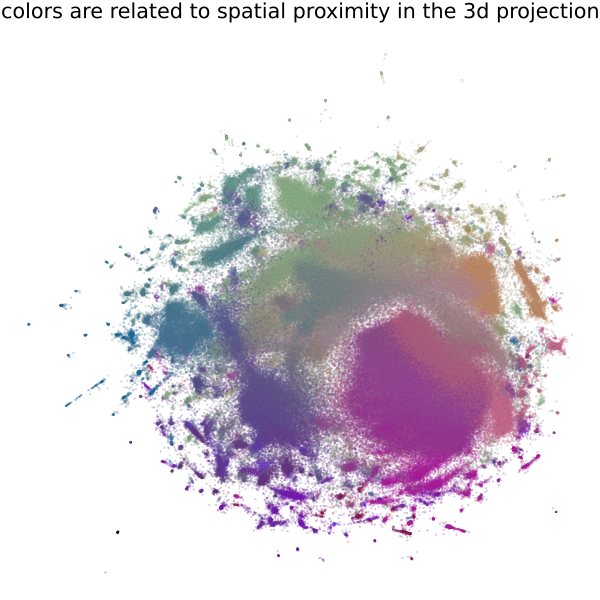

In [10]:
plot_umap(e2, e3)

# Final notes

This example shows how to index and search dense vector databases, in particular GloVe word embeddings using the cosine distance. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [11]:
Pkg.status()

      Status `~/Research/SimilaritySearchDemos/Glove/Project.toml`
  [c5bfea45] Embeddings v0.4.2
  [ac1192a8] HypertextLiteral v0.9.4
  [033835bb] JLD2 v0.4.22
  [91a5bcdd] Plots v1.30.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.4
  [053f045d] SimilaritySearch v0.9.2
